In [1]:
import cv2,os,time
os.sys.path.append('../utilities/')
from datetime import datetime
import numpy as np
import IPython.display as Disp
import support_utility_openvino
import matplotlib.pyplot as plt
import ipywidgets as widgets
from shapely.geometry import Polygon,Point
import numpy as np

In [2]:
output_support = support_utility_openvino.create_plot()

##### class for selecting area of interest

In [3]:
import matplotlib.pyplot as plt
import IPython.display as Disp
import ipywidgets as widgets

class bbox_select():
    %matplotlib notebook



    def __init__(self,im):
        self.im = im
        self.selected_points = []
        self.fig,ax = plt.subplots()
        self.img = ax.imshow(self.im.copy())
        self.ka = self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        disconnect_button = widgets.Button(description="Disconnect mpl")
        Disp.display(disconnect_button)
        disconnect_button.on_click(self.disconnect_mpl)


        
    def poly_img(self,img,pts):
        pts = np.array(pts, np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.polylines(img,[pts],True,(0,255,255),4)
        return img

    def onclick(self, event):
    #display(str(event))
        self.selected_points.append([event.xdata,event.ydata])
        if len(self.selected_points)>1:
            self.fig
            self.img.set_data(self.poly_img(self.im.copy(),self.selected_points))
    def disconnect_mpl(self,_):
        self.fig.canvas.mpl_disconnect(self.ka)

        
            

- support functions

In [4]:
def point_intersection_shapely(polygon, point):
    """
    polygon : set of points for polygon[[x1,y1],[x2,y2]] 
    point : set of points for polygon[x3,y3] 
    returns true or false
    """
    p1 = Polygon(polygon)
    return p1.contains(Point(point))


def poly_intersection_shapely(pt1,pt2,intersection_threshold=.1):
    """
    pt1 : set of points for polygon 1 [[x1,y1],[x2,y2]] 
    pt2 : set of points for polygon 2[[x1,y1],[x2,y2]] 
    intersection theshold : intersection threshold for polygon intersection considered with ref to pt2
    bool : return True or False
    """

    p1 = Polygon(pt1)
    p2 = Polygon(pt2)
    intersection_area = p1.intersection(p2).area
    if intersection_area/p2.area>intersection_threshold:
        return True
    return False
def filter_result_bbox(frame,result,thresh=.4):
    initial_w,initial_h = frame.shape[1],frame.shape[0]
    res_filt =  result[np.where(result[:,:,:,2]>thresh)]
    res_filt = res_filt[np.min(res_filt,axis=1)>=0]
    class_ids = res_filt[:,1].astype(int)
    bboxes = np.multiply([[initial_w,initial_h,initial_w,initial_h]],(res_filt[:,3:])).astype('int')
    return bboxes

#### create ROI

In [5]:
channel = "/media/prateek/shared_space/DATA_N_MODELS/useful_vids/general/veraval/helmet_vest/CSY_IP Camera15_CSY_20340104021919_20340104021928_17675913.mp4"

In [6]:
cap = cv2.VideoCapture(channel)
ret,frame = cap.read()

<IPython.core.display.Javascript object>


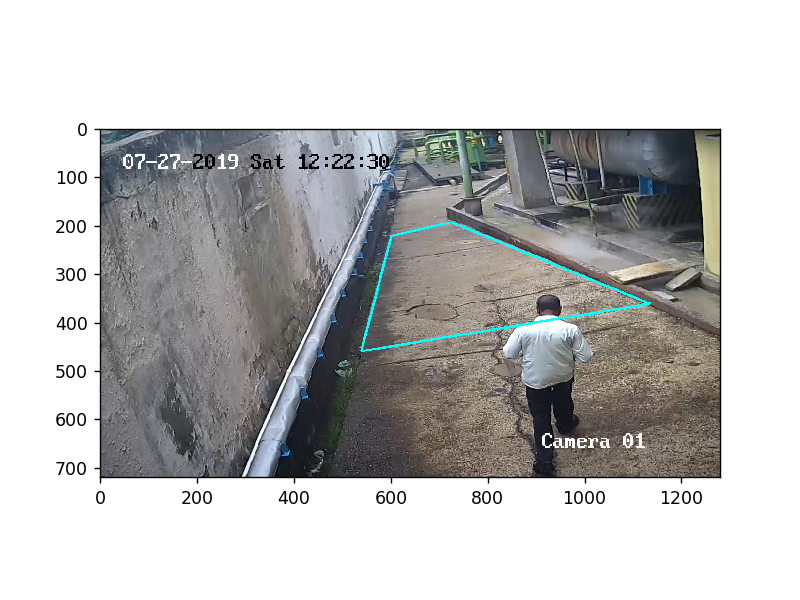

Button(description='Disconnect mpl', style=ButtonStyle())

In [7]:
bs = bbox_select(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [8]:
### selected points
bs.selected_points

[[601.306404359879, 222.98387096774195],
 [725.1773721018144, 194.5967741935484],
 [1135.4999527469756, 362.3387096774194],
 [539.3709204889112, 460.4032258064516]]

In [13]:
# masked_image = np.multiply(image.copy(),
#                            cv2.fillPoly(np.zeros(image.shape, np.uint8),
#                                         np.array([image_dict['model_config']['roi']], 'int'),
#                                         [1, 1, 1]))

#### loading model

In [9]:
model_path = '/home/prateek/prateek_space/intel_model_dump/intel/person-detection-0100/FP32/person-detection-0100.xml'
# model_path = '/home/prateek/prateek_space/model_files/openvino_model/2020_07_11_person_detection/frozen_inference_graph.xml'
# model_path = "/home/prateek/prateek_space/model_files/openvino_model/2020_08_22_person_detection/frozen_inference_graph.xml"
model_path = "/media/prateek/shared_space/Notebooks/git_repos/openvino_training_extensions/pytorch_toolkit/object_detection/custom_model/person_detection_1/outputs/openvino/alt_ssd_export/2020_03_18_person_detection.xml"
model_path = "/media/prateek/shared_space/DATA_N_MODELS/useful_models/person_detection/2021_07_29_person-detection-0200/alt_ssd_export/model.xml"
threshold = .5
device = 'CPU'

person_detection = support_utility_openvino.async_infer(4)
person_detection.load_model(model_path=model_path,device=device)

Available Devices :  ['CPU', 'GNA', 'GPU']
OPTIMIZATION_CAPABILITIES for CPU:  ['FP32', 'FP16', 'INT8', 'BIN']
model inputs : dict_keys(['image'])
model outputs :  dict_keys(['detection_out'])


In [16]:
def convert2altssd(res,shape):
    """
    res : original output
    shape : shape of image
    
    original output = dict_keys(['TopK_1181.0', 'TopK_1415.0', 'TopK_1649.0', 'TopK_1883.0', 'TopK_947.0', 'boxes', 'labels'])
   
   The boxes is a blob with shape: [N, 5], where N is the number of detected bounding boxes.
   For each detection, the description has the format: [x_min, y_min, x_max, y_max, conf], where:
        (x_min, y_min) - coordinates of the top left bounding box corner
        (x_max, y_max) - coordinates of the bottom right bounding box corner.
    conf - confidence for the predicted class
    The labels is a blob with shape: [N], where N is the number of detected bounding boxes. 
    In case of person detection, it is equal to 1 for each detected box with person in it and 0 for the background.

    converted_output = [image_id, label, conf, x_min, y_min, x_max, y_max]
    """
    labels = res[-1]
    boxes = res[-2]
    output = np.ones(shape=(boxes.shape[0],7))
    output[:,1] = labels+1
    output[:,3:] = boxes[:,[0,1,2,3]]/(initial_w,initial_h,initial_w,initial_h)
    output[:,2] = boxes[:,-1]
    return output


#### for video

In [10]:
# channel = "/media/prateek/shared_space/DATA_N_MODELS/useful_vids/1/helmet_vest/CSY_IP Camera15_CSY_20340104021919_20340104021928_17675913.mp4"
write_video = False
show_bbox = True
fps_async = []
cap = cv2.VideoCapture(channel)
initial_w,initial_h = cap.get(3), cap.get(4)

# for idx,channel in enumerate(glob.glob("/media/prateek/prateek_space/helmet_n_vest/test_data/2019_09_12_Taloja_video_data/2019-09-12/stacker _bay_hot_mill_side_view/*")):
#     cap = cv2.VideoCapture(channel)
thresh = .5
intersection_thresh = .1
cv2.namedWindow("preview",cv2.WINDOW_NORMAL)
cap.set(1,0)
person_detection.reinit_model()
if write_video:
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    videowriter = cv2.VideoWriter("../output_vids/intrusion/veraval/"+"h2bottling"+".mp4",fourcc, 10, (int(cap.get(3)),int(cap.get(4))))
while True:
    t0 = time.time() 
    ret, frame = cap.read()
#     frame = cv2.resize(frame,(1344,756))

    if not ret:
        break
       
    person_detection.predict(frame)
    if person_detection.frame_processed>=person_detection.num_requests:
        frame,attr,res = person_detection.postprocess_op()
#         res = [np.expand_dims(convert2altssd(res,(initial_w,initial_h)),[0,1])]
        bboxes = filter_result_bbox(frame,res[0],thresh = thresh)
        t1 = time.time()    
        fps_async.append(1/(t1-t0))

        res_filt =  res[0][np.where(res[0][:,:,:,2]>thresh)]
        bboxes = np.multiply([[initial_w,initial_h,initial_w,initial_h]],(res_filt[:,3:])).astype('int')
        if show_bbox:
            frame = bs.poly_img(frame,bs.selected_points)
        for b in bboxes:
        ## mask based intersection
#             intersection = poly_intersection_mask(frame,bs.selected_points,[[b[0],b[1]],[b[2],b[1]],[b[2],b[3]],[b[0],b[3]]])
#             print(intersection)
            
            if poly_intersection_shapely(bs.selected_points,[[b[0],b[1]],[b[2],b[1]],[b[2],b[3]],[b[0],b[3]]],intersection_threshold=intersection_thresh)and(point_intersection_shapely(bs.selected_points,[b[0],b[3]]) or point_intersection_shapely(bs.selected_points,[b[2],b[3]])):
                cv2.rectangle(frame, (b[0], b[1]), (b[2], b[3]), (0,0,255), 2)            
            else:
                # if not intersecting
#                 pass
                cv2.rectangle(frame, (b[0], b[1]), (b[2], b[3]), (0,0,0), 2)
        frame = output_support.write_text(frame,"FPS :%.2f"%np.median(fps_async),text_color=(0, 0, 0),font_scale=1)
        
#         dst = cv2.warpPerspective(frame,M,(int(width),int(height)))
        if write_video:
            videowriter.write(frame)
        cv2.imshow("preview",frame)
        k = cv2.waitKey(0)
        if k==ord('q'):
            break

if write_video:
    videowriter.release()
cv2.destroyAllWindows()
cap.release()



####  for images

In [6]:
file_path = "/media/prateek/shared_space/DATA_N_MODELS/useful_vids/Renukoot_Hindalco/INTRUSION/intrusion/"
def get_all_file_path(source_dir,ext='.csv'):
    """
    all images with csv extension exist in set of dirs
    """
    op =[]
    for root, dirs, files in os.walk(source_dir):
        for file in files:
            if file.endswith(ext):
                
                 op.append(os.path.join(os.path.abspath(root), file))
    return op
all_jpg = get_all_file_path(file_path,".jpg")

In [7]:
model_path = "/media/prateek/shared_space/Notebooks/git_repos/openvino_training_extensions/pytorch_toolkit/object_detection/custom_model/person_detection/export/alt_ssd_export/model.xml"
# model_path = '/home/prateek/prateek_space/model_files/openvino_model/2020_07_11_person_detection/frozen_inference_graph.xml'
# model_path = "/media/prateek/PK_HDD/intel_model_zoo/intel/person-detection-0202/FP32/person-detection-0202.xml"
model_path = "/media/prateek/shared_space/DATA_N_MODELS/useful_models/helmet_vest/2021_06_22_person_detection/model (1).xml"
model_path = "/media/prateek/shared_space/DATA_N_MODELS/useful_models/person_detection/2021_07_28_person-detection-0201/model.xml"
model_path = "/media/prateek/shared_space/DATA_N_MODELS/useful_models/person_detection/2021_07_29_person-detection-0200/alt_ssd_export/model.xml"

threshold = .5
device = 'CPU'

person_detection = support_utility_openvino.async_infer(4)
person_detection.load_model(model_path=model_path,device=device)

Available Devices :  ['CPU', 'GNA', 'GPU']
OPTIMIZATION_CAPABILITIES for CPU:  ['FP32', 'FP16', 'INT8', 'BIN']
model inputs : dict_keys(['image'])
model outputs :  dict_keys(['detection_out'])


In [10]:
thresh = .5
intersection_thresh = .1
waittime = 0
person_detection.reinit_model()
fps_async = []
show_bbox = False
cv2.namedWindow("preview",cv2.WINDOW_NORMAL)
write_frames = False
if write_frames:
    save_path = "../output_vids/person_detection/vikram_wollens/"
    os.makedirs(save_path,exist_ok=True)
    image_idx = 0
for f in all_jpg:
    t0 = time.time() 
    frame = cv2.imread(f)
    person_detection.predict(frame)
    if person_detection.frame_processed>person_detection.num_requests:
        frame,attr,res = person_detection.postprocess_op()
        initial_w,initial_h = frame.shape[1],frame.shape[0]
        bboxes = filter_result_bbox(frame,res[0],thresh = thresh)
        t1 = time.time()    
        fps_async.append(1/(t1-t0))

        res_filt =  res[0][np.where(res[0][:,:,:,2]>thresh)]
        bboxes = np.multiply([[initial_w,initial_h,initial_w,initial_h]],(res_filt[:,3:])).astype('int')
        if show_bbox:
            frame = bs.poly_img(frame,bs.selected_points)
        for b in bboxes:
        ## mask based intersection
    #             intersection = poly_intersection_mask(frame,bs.selected_points,[[b[0],b[1]],[b[2],b[1]],[b[2],b[3]],[b[0],b[3]]])
    #             print(intersection)

#             if poly_intersection_shapely(bs.selected_points,[[b[0],b[1]],[b[2],b[1]],[b[2],b[3]],[b[0],b[3]]],intersection_threshold=intersection_thresh)and(point_intersection_shapely(bs.selected_points,[b[0],b[3]]) or point_intersection_shapely(bs.selected_points,[b[2],b[3]])):
#                 cv2.rectangle(frame, (b[0], b[1]), (b[2], b[3]), (0,0,255), 2)            
#             else:
#                 # if not intersecting
#     #                 pass
            cv2.rectangle(frame, (b[0], b[1]), (b[2], b[3]), (0,0,0), 2)
        frame = output_support.write_text(frame,"FPS :%.2f"%np.median(fps_async),text_color=(0, 0, 0),font_scale=1)

    #         dst = cv2.warpPerspective(frame,M,(int(width),int(height)))
        if write_frames:
            cv2.imwrite(os.path.join(save_path,str(image_idx).zfill(5)+".jpg"),frame)
            image_idx+=1

        cv2.imshow("preview",cv2.resize(frame,(640,480)))
        k = cv2.waitKey(waittime)
        if k==ord('s'):#switch
            if waittime==1:
                    waittime = 0
            else:
                waittime = 1
        if k==ord('q'):
            break


cv2.destroyAllWindows()

In [21]:
cv2.imwrite(os.path.join(save_path,str(image_idx).zfill(5),".jpg"),frame)

False

In [22]:
os.path.join(save_path,str(image_idx).zfill(5),".jpg")

'../output_vids/person_detection/vikram_wollens/00116/.jpg'

In [12]:
res_filt

array([[ 0.0000000e+00,  0.0000000e+00,  9.9953628e-01,  2.3047870e-01,
         6.0898048e-01,  3.7055230e-01,  1.0031750e+00],
       [ 0.0000000e+00,  0.0000000e+00,  9.7986335e-01, -2.2630021e-04,
         3.4625381e-02,  5.8898468e-02,  3.5967714e-01],
       [ 0.0000000e+00,  0.0000000e+00,  9.0268028e-01,  1.4381246e-01,
         3.8524479e-01,  2.6019394e-01,  7.5876504e-01],
       [ 0.0000000e+00,  0.0000000e+00,  8.1660497e-01,  6.6988803e-02,
         2.1312848e-02,  1.5743464e-01,  3.7454534e-01]], dtype=float32)